Model training!

In [1]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.model_selection import StratifiedShuffleSplit

def modify_data():
    df = pd.read_csv('train.csv')
    df['Survived'] = df['Survived'].astype('category')
    age_median = df['Age'].median()
    df['Age'] = df['Age'].replace(0, age_median)
    df['Child'] = df['Age'].between(0, 16, inclusive='both')
    df['Adult'] = df['Age'].between(17, 45, inclusive='both')
    df['Senior'] = df['Age'].between(46, 100, inclusive='both')
    df['Fare_log'] = np.log1p(df['Fare'])
    df['cabin_height'] = df['Cabin'].str[0].fillna('U')
    df['Embarked'] = df['Embarked'].fillna(0)

    procs = [Categorify, Normalize]
    cat_names  = ['Sex','Embarked','cabin_height','Pclass']
    cont_names = ['Fare_log','Child','Adult','Senior','SibSp','Parch']
    
    return build_base(df, procs, cat_names, cont_names)

def build_base(df,procs,cat_names,cont_names):

    tp = TabularPandas(
        df, 
        procs=procs,
        cat_names=cat_names, 
        cont_names=cont_names,
        y_names='Survived',
        y_block=RegressionBlock(),
        splits = RandomSplitter(0.2)(range_of(df)),
        )
    dls  = tp.dataloaders(path='.')
    learn = tabular_learner(
        dls,
        layers=[200,100],
        loss_func=MSELossFlat(),
        wd=0.1,
        metrics=[rmse, mae, R2Score()]
    )

    return df, learn,tp, dls, cat_names, cont_names

def get_valid_data(learn, dls):
    valid_loss, rmse_val, mae_val, r2_val = learn.validate()
    print(f"Valid Loss (MSE):       {valid_loss:.4f}")
    print(f"Valid RMSE:             {rmse_val:.4f}")
    print(f"Valid MAE:              {mae_val:.4f}")
    print(f"Valid R² score:         {r2_val:.4f}")
    # run the finder
    learn.lr_find()


In [2]:
df, learn, tp, dls, cat_names, cont_names = modify_data()


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = tp.items
df[cont_names] = df[cont_names]
X = df[cont_names + cat_names]
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


In [4]:

model = RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42)
model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5).mean()

print("Train accuracy:", model.score(X_train, y_train))
print("Val accuracy:  ", model.score(X_val, y_val))

Train accuracy: 0.8216292134831461
Val accuracy:   0.7877094972067039


In [ ]:

for n in [10, 25, 50, 100]:
    rf = RandomForestClassifier(n_estimators=n, max_depth=4, random_state=42)
    rf.fit(X_train, y_train)
    print(f"{n} trees → Train: {rf.score(X_train, y_train):.3f} | Val: {rf.score(X_val, y_val):.3f}")

In [6]:
import joblib

# Save to a file
joblib.dump({'model': model, 'procs': tp.procs, 'columns': X_train.columns.tolist()}, 'rf_model_bundle.pkl')

['rf_model_bundle.pkl']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = tp.items
X = df[cont_names + cat_names]
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

print("Train accuracy:", model.score(X_train, y_train))
print("Val accuracy:  ", model.score(X_val, y_val))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = tp.items
X = df[cont_names + cat_names]
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

print("Train accuracy:", model.score(X_train, y_train))
print("Val accuracy:  ", model.score(X_val, y_val))

In [3]:
print("4 epochs, slice(1e-4, 1e-2)")
learn= tabular_learner(
        dls,
        layers=[200,100],
        loss_func=MSELossFlat(),
        wd=0.1,
        metrics=[rmse, mae, R2Score()]
    )
learn.fit_one_cycle(5, slice(1e-4, 1e-2))


4 epochs, slice(1e-4, 1e-2)


epoch,train_loss,valid_loss,_rmse,mae,r2_score,time
0,0.448424,0.385531,0.620911,0.443380,-0.561842,00:00
1,0.306781,0.240368,0.490273,0.394663,0.026235,00:00
2,0.238905,0.193119,0.439453,0.336836,0.217648,00:00
3,0.201436,0.174981,0.418308,0.306592,0.291126,00:00
4,0.177771,0.164313,0.405356,0.290866,0.334343,00:00


Valid Loss (MSE):       0.1643
Valid RMSE:             0.4054
Valid MAE:              0.2909
Valid R² score:         0.3343


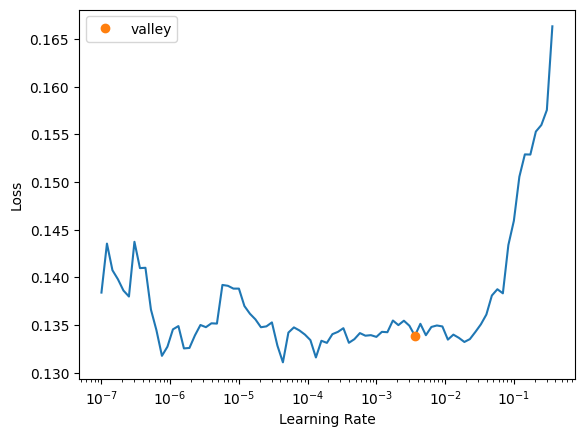

In [4]:
get_valid_data(learn,dls)

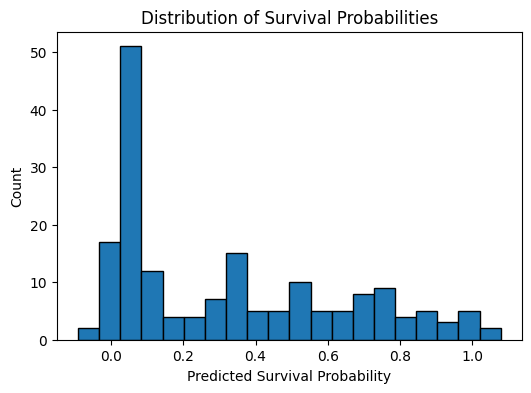

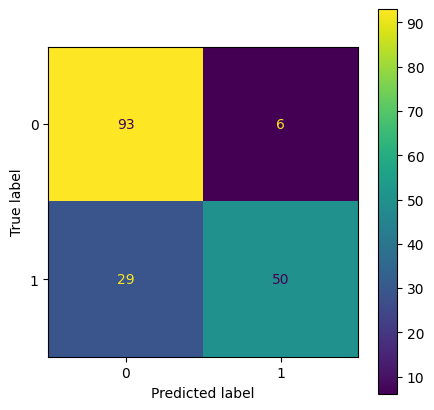

Total misclassified: 35


KeyError: 'Age_na'

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import pandas as pd

# 1. Get model outputs & true targets on the valid set
probs_val, targs_val = learn.get_preds(dl=learn.dls.valid)
# ——> probs_val: (n_valid, n_classes) or (n_valid,1) if regressor
# ——> targs_val: (n_valid,)
surv_probs = probs_val[:,1] if probs_val.shape[1] > 1 else probs_val.squeeze()
plt.figure(figsize=(6,4))
plt.hist(surv_probs.numpy(), bins=20, edgecolor='k')
plt.xlabel('Predicted Survival Probability')
plt.ylabel('Count')
plt.title('Distribution of Survival Probabilities')
plt.show()
# 2. Turn those into hard labels
# If you have a 2‐class softmax head:
preds_class = (probs_val.squeeze() > 0.5).int()

# 3. Compute & plot the confusion matrix
cm = confusion_matrix(targs_val.cpu(), preds_class.cpu())

fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

# 4. Grab your original valid‐set DataFrame
valid_df = learn.dls.valid.dataset.items.copy()

# 5. Annotate with predictions and ground truth
valid_df['predicted'] = preds_class.numpy()
valid_df['actual']    = targs_val.numpy()

# 6. Filter to only the misclassified rows
misclassified = valid_df[valid_df['predicted'] != valid_df['actual']]

# 7. Inspect
print(f"Total misclassified: {len(misclassified)}")
misclassified.head()
age_na_count = misclassified[misclassified['Age_na'] == 2]
print(f"Number of rows with missing Age: {len(age_na_count)}")


In [6]:
df = misclassified.copy()
not_dead = df[df['predicted'] == 1]
count_nd_female = (not_dead['Sex'] ==2).sum()
print(f"predict alive, false: {count_nd_female}")


dead = df[df['predicted'] == 0]
count_d_female = (dead['Sex'] ==2).sum()
print(f"predict dead, false: {count_d_female}")

c_not_dead = df[df['predicted'] == 0]
count_c_not = (c_not_dead['Child'] == 0).sum()
print(f"predict alive, false, child: {count_c_not}")

a_not_dead = df[df['predicted'] == 0]
count_a_not = (a_not_dead['Adult'] == 0).sum()
print(f"predict alive, false, adult: {count_a_not}")

s_not_dead = df[df['predicted'] == 0]
count_s_not = (s_not_dead['Senior'] == 0).sum()
print(f"predict alive, false, senior: {count_s_not}")

predict alive, false: 2
predict dead, false: 23
predict alive, false, child: 0
predict alive, false, adult: 0
predict alive, false, senior: 0


In [ ]:
males_misclassified = (df['Sex'] == 1).sum()
print(f"count of misclassified males = {males_misclassified}")

In [ ]:
learn.export('titanic_model_v7.pkl')